# Preprocessing and Training Data Development

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data_wrangling.csv', parse_dates=['InvoiceDate'])
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,CustomerID,Country,ItemTotal
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [3]:
# get the time range of the dataset
print(df.InvoiceDate.min(), df.InvoiceDate.max())
print((df.InvoiceDate.max() - df.InvoiceDate.min())/np.timedelta64(1, 'M'))

2009-12-01 07:45:00 2011-12-09 12:50:00
24.25386330086632


**The dataset has a total of 24 months of sales data. We will take 3 months of data, calculate RFM and use it for predicting the next 21 months.**

In [4]:
# create 3-month and 21-month dataframes 
df_3m = df[(df.InvoiceDate >= datetime(2009,12,1)) & (df.InvoiceDate < datetime(2010,3,1))]
df_21m = df[(df.InvoiceDate >= datetime(2010,3,1)) & (df.InvoiceDate < datetime(2011,12,1))]

In [5]:
# create a new dataframe to store CustomerID and the new features
customers = pd.DataFrame(df_3m['CustomerID'].unique())
customers.columns = ['CustomerID']
customers.head()

,CustomerID
0,13085
1,13078
2,15362
3,18102
4,12682


In [6]:
# create order cluster funtion

def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

### Recency Score

In [7]:
# get the most recent purchase date for each customer
df_recency = df_3m.groupby('CustomerID').InvoiceDate.max().rename('RecentPurchaseDate').reset_index()
df_recency.head()

,CustomerID,RecentPurchaseDate
0,12346,2010-01-26 17:27:00
1,12349,2009-12-04 12:49:00
2,12358,2009-12-08 07:59:00
3,12359,2009-12-16 15:39:00
4,12360,2010-02-22 09:32:00


In [8]:
# calculate the days between the recent puchase for each customer and the most recent purchase of the entire dataset
# this is the recency feature
df_recency['Recency'] = (df_recency['RecentPurchaseDate'].max() - df_recency['RecentPurchaseDate']).dt.days
df_recency.head()

,CustomerID,RecentPurchaseDate,Recency
0,12346,2010-01-26 17:27:00,32
1,12349,2009-12-04 12:49:00,86
2,12358,2009-12-08 07:59:00,82
3,12359,2009-12-16 15:39:00,74
4,12360,2010-02-22 09:32:00,6


In [9]:
# add the Recency feature to the dataframe
customers = customers.merge(df_recency[['CustomerID','Recency']], how='left', on='CustomerID')
customers.head()

,CustomerID,Recency
0,13085,30
1,13078,12
2,15362,89
3,18102,2
4,12682,5


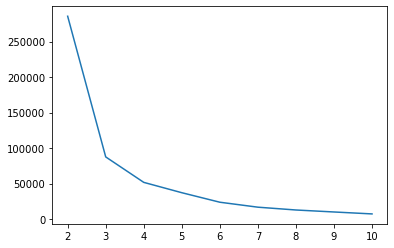

In [10]:
# use elbow method to pick the best K to cluster

Ks = range(2,11)
SS = []
for K in Ks:
    kmeans = KMeans(n_clusters=K, random_state=0)
    kmeans.fit(customers[['Recency']])
    SS.append(kmeans.inertia_)
    
plt.plot(Ks, SS)

In [11]:
# create 4 recency clusters and assign to each customer
kmeans = KMeans(n_clusters=4, random_state=0)
customers['RecencyCluster'] = kmeans.fit_predict(customers[['Recency']])
customers.head()

,CustomerID,Recency,RecencyCluster
0,13085,30,0
1,13078,12,2
2,15362,89,1
3,18102,2,2
4,12682,5,2


In [12]:
# check summary statistics for each cluster
customers.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,481.0,27.274428,5.216515,18.0,23.0,28.0,32.0,35.0
1,514.0,80.060311,5.946665,67.0,75.0,81.0,86.0,89.0
2,566.0,7.540636,4.978283,0.0,3.0,7.0,12.0,17.0
3,239.0,43.828452,5.188856,36.0,39.0,42.0,48.0,55.0


In [13]:
# order recency clusters
customers = order_cluster('RecencyCluster', 'Recency', customers, False)
customers.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,514.0,80.060311,5.946665,67.0,75.0,81.0,86.0,89.0
1,239.0,43.828452,5.188856,36.0,39.0,42.0,48.0,55.0
2,481.0,27.274428,5.216515,18.0,23.0,28.0,32.0,35.0
3,566.0,7.540636,4.978283,0.0,3.0,7.0,12.0,17.0


### Frequency Score

In [14]:
# calculate freqency feature for each customer and add it to the dataframe
df_frequency = df_3m.groupby('CustomerID').InvoiceDate.count().rename('Frequency').reset_index()
customers = customers.merge(df_frequency,how='left',on='CustomerID')

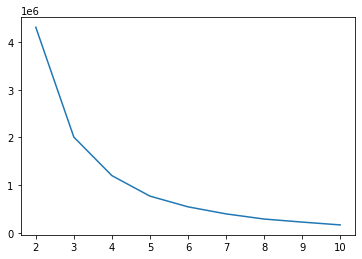

In [15]:
# user elbow method to pick the K
Ks = range(2,11)
SS = []
for K in Ks:
    kmeans = KMeans(n_clusters=K,random_state=0)
    kmeans.fit(customers[['Frequency']])
    SS.append(kmeans.inertia_)
    
plt.plot(Ks,SS)

In [16]:
# create 4 frequency clusters and assign to each customer
kmeans = KMeans(n_clusters=4, random_state=0)
customers['FrequencyCluster'] = kmeans.fit_predict(customers[['Frequency']])
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,13085,30,2,62,2
1,18087,23,2,35,0
2,14110,28,2,35,0
3,13758,23,2,105,2
4,17865,20,2,184,2


In [17]:
# check summary statistics for each frequency cluster
customers.groupby('FrequencyCluster').Frequency.describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1474.0,22.104478,16.242183,1.0,8.25,19.0,33.0,61.0
1,7.0,857.000000,208.960921,628.0,706.50,798.0,1008.5,1143.0
2,286.0,100.562937,33.382229,62.0,72.00,90.5,121.0,192.0
3,33.0,291.575758,85.321462,199.0,225.00,255.0,350.0,540.0


In [18]:
# order frequency clusters
customers = order_cluster('FrequencyCluster', 'Frequency', customers, True)
customers.groupby('FrequencyCluster').Frequency.describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1474.0,22.104478,16.242183,1.0,8.25,19.0,33.0,61.0
1,286.0,100.562937,33.382229,62.0,72.00,90.5,121.0,192.0
2,33.0,291.575758,85.321462,199.0,225.00,255.0,350.0,540.0
3,7.0,857.000000,208.960921,628.0,706.50,798.0,1008.5,1143.0


### Moneytary Value Score

In [19]:
# calculate revenue for each customer and add it to the dataframe
df_revenue = df_3m.groupby('CustomerID').ItemTotal.sum().rename('Revenue').reset_index()
customers = customers.merge(df_revenue, how='left', on='CustomerID')
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,13085,30,2,62,1,2017.20
1,13758,23,2,105,1,2981.40
2,17865,20,2,184,1,4234.84
3,17611,35,2,150,1,934.63
4,13097,33,2,161,1,1750.75


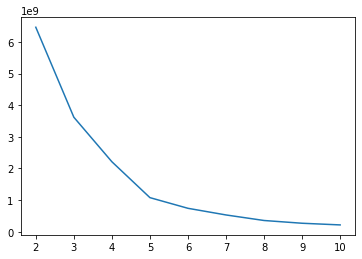

In [20]:
# user elbow method to pick the K
Ks = range(2,11)
SS = []
for K in Ks:
    kmeans = KMeans(n_clusters=K,random_state=0)
    kmeans.fit(customers[['Revenue']])
    SS.append(kmeans.inertia_)
    
plt.plot(Ks,SS)

In [21]:
# create 4 frequency clusters and assign to each customer
kmeans = KMeans(n_clusters=5, random_state=0)
customers['RevenueCluster'] = kmeans.fit_predict(customers[['Revenue']])

# check summary statistics for each revenue cluster
customers.groupby('RevenueCluster').Revenue.describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1689.0,487.490920,458.001823,-1426.21,181.6500,339.180,667.6200,2347.05
1,1.0,101837.940000,NaN,101837.94,101837.9400,101837.940,101837.9400,101837.94
2,9.0,17972.588889,4288.026704,11747.64,16299.1700,16990.240,20372.6300,24148.28
3,3.0,58516.720000,11474.037613,46682.53,52978.5650,59274.600,64433.8150,69593.03
4,98.0,4241.270143,1798.787266,2391.56,2959.9225,3458.025,5113.2725,9722.82


In [22]:
# order revenue clusters
customers = order_cluster('RevenueCluster','Revenue',customers,True)
customers.groupby('RevenueCluster').Revenue.describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1689.0,487.490920,458.001823,-1426.21,181.6500,339.180,667.6200,2347.05
1,98.0,4241.270143,1798.787266,2391.56,2959.9225,3458.025,5113.2725,9722.82
2,9.0,17972.588889,4288.026704,11747.64,16299.1700,16990.240,20372.6300,24148.28
3,3.0,58516.720000,11474.037613,46682.53,52978.5650,59274.600,64433.8150,69593.03
4,1.0,101837.940000,NaN,101837.94,101837.9400,101837.940,101837.9400,101837.94


In [23]:
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,13085,30,2,62,1,2017.20,0
1,17611,35,2,150,1,934.63,0
2,13097,33,2,161,1,1750.75,0
3,13819,20,2,68,1,1490.75,0
4,17191,30,2,64,1,537.81,0


### RFM Score

In [24]:
# calculate total score for each customer
customers['RFM'] = customers['RecencyCluster'] + customers['FrequencyCluster'] + customers['RevenueCluster']
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM
0,13085,30,2,62,1,2017.20,0,3
1,17611,35,2,150,1,934.63,0,3
2,13097,33,2,161,1,1750.75,0,3
3,13819,20,2,68,1,1490.75,0,3
4,17191,30,2,64,1,537.81,0,3


In [25]:
# check summary statistics for RFM scores
customers.groupby('RFM')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
RFM,,,
0,80.274428,17.505198,275.554678
1,48.281513,30.722689,483.375168
2,28.788698,26.921376,482.339735
3,12.080851,39.189362,668.307962
4,8.393939,99.772727,1756.754697
5,6.738095,140.214286,4711.703905
6,4.777778,295.833333,5637.487222
7,3.200000,716.800000,9999.746000
8,3.000000,612.200000,33493.656000


LTV Cluster

In [26]:
# calculate 21 months LTV for each customer
df_21m_revenue = df_21m.groupby('CustomerID').ItemTotal.sum().rename('Revenue21m').reset_index()
df_21m_revenue

,CustomerID,Revenue21m
0,12346,-151.74
1,12347,4696.71
2,12348,2019.40
3,12349,4428.69
4,12350,334.40
...,...,...
5670,18282,98.76
5671,18283,2360.00
5672,18284,436.68
5673,18286,725.48


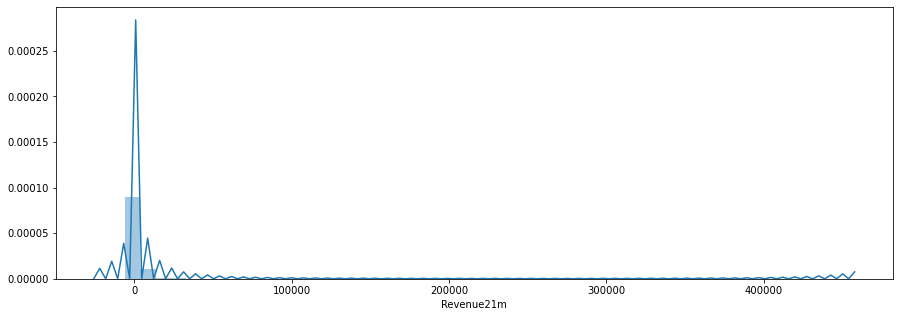

In [27]:
plt.figure(figsize=(15,5))
sns.distplot(df_21m_revenue.Revenue21m)

In [28]:
# add 21 months LTV to the customers dataframe
customers = customers.merge(df_21m_revenue,how='left',on='CustomerID')
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM,Revenue21m
0,13085,30,2,62,1,2017.20,0,3,-557.74
1,17611,35,2,150,1,934.63,0,3,6936.00
2,13097,33,2,161,1,1750.75,0,3,11045.86
3,13819,20,2,68,1,1490.75,0,3,1140.35
4,17191,30,2,64,1,537.81,0,3,3747.03


In [29]:
# fill in missing 21 months revenue as 0
customers.fillna(0,inplace=True)
customers.isnull().sum()

CustomerID          0
Recency             0
RecencyCluster      0
Frequency           0
FrequencyCluster    0
Revenue             0
RevenueCluster      0
RFM                 0
Revenue21m          0
dtype: int64

In [30]:
# winsorize outliers
winsorize(customers['Revenue21m'], limits=[0.01, 0.01], inplace=True)
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM,Revenue21m
0,13085,30,2,62,1,2017.20,0,3,-2.95
1,17611,35,2,150,1,934.63,0,3,6936.00
2,13097,33,2,161,1,1750.75,0,3,11045.86
3,13819,20,2,68,1,1490.75,0,3,1140.35
4,17191,30,2,64,1,537.81,0,3,3747.03


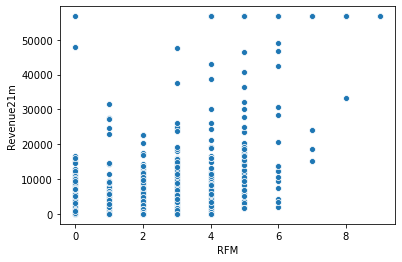

In [31]:
# examine the correlation between RFM score and 21 months LTV
sns.scatterplot('RFM','Revenue21m',data=customers)

In [32]:
# create 3 LTV clusters and assign to each customer
kmeans = KMeans(n_clusters=3, random_state=0)
customers['LTVCluster'] = kmeans.fit_predict(customers[['Revenue21m']])
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM,Revenue21m,LTVCluster
0,13085,30,2,62,1,2017.20,0,3,-2.95,0
1,17611,35,2,150,1,934.63,0,3,6936.00,0
2,13097,33,2,161,1,1750.75,0,3,11045.86,2
3,13819,20,2,68,1,1490.75,0,3,1140.35,0
4,17191,30,2,64,1,537.81,0,3,3747.03,0


In [33]:
# order LTV clusters: 0-low LTV, 1-Mid LTV, 2-High LTV
customers = order_cluster('LTVCluster','Revenue21m',customers,True)
customers.groupby('LTVCluster').Revenue21m.describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1585.0,1812.324451,1912.232878,-2.95,291.500,1092.810,2839.42,7731.59
1,184.0,13682.271527,5799.227493,7796.85,9362.785,11665.155,16041.70,32212.04
2,31.0,51246.840000,7698.467473,33417.53,46611.030,56753.010,56753.01,56753.01


In [34]:
# add country as a feature to the customer dataframe
customers = customers.merge(df_3m[['CustomerID','Country']],how='left',on='CustomerID')
customers

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM,Revenue21m,LTVCluster,Country
0,13085,30,2,62,1,2017.20,0,3,-2.95,0,United Kingdom
1,13085,30,2,62,1,2017.20,0,3,-2.95,0,United Kingdom
2,13085,30,2,62,1,2017.20,0,3,-2.95,0,United Kingdom
3,13085,30,2,62,1,2017.20,0,3,-2.95,0,United Kingdom
4,13085,30,2,62,1,2017.20,0,3,-2.95,0,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...
76959,14156,5,3,628,3,69593.03,3,9,56753.01,2,EIRE
76960,14156,5,3,628,3,69593.03,3,9,56753.01,2,EIRE
76961,14156,5,3,628,3,69593.03,3,9,56753.01,2,EIRE
76962,14156,5,3,628,3,69593.03,3,9,56753.01,2,EIRE


In [35]:
# get dummy featues for country feature
customers = pd.get_dummies(customers, drop_first=True)
customers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM,Revenue21m,LTVCluster,...,Country_Poland,Country_Portugal,Country_RSA,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,13085,30,2,62,1,2017.2,0,3,-2.95,0,...,0,0,0,0,0,0,0,0,1,0
1,13085,30,2,62,1,2017.2,0,3,-2.95,0,...,0,0,0,0,0,0,0,0,1,0
2,13085,30,2,62,1,2017.2,0,3,-2.95,0,...,0,0,0,0,0,0,0,0,1,0
3,13085,30,2,62,1,2017.2,0,3,-2.95,0,...,0,0,0,0,0,0,0,0,1,0
4,13085,30,2,62,1,2017.2,0,3,-2.95,0,...,0,0,0,0,0,0,0,0,1,0


In [36]:
# create the feature set X and label y
X = customers.drop(['CustomerID','Revenue21m','LTVCluster'],axis=1)
y = customers.LTVCluster

In [38]:
# split training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)